# Imports

In [1]:
import numpy as np
import time
import itertools as it

import matplotlib.pylab as plt
import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
import pickle

import dynesty
from dynesty import plotting as dyplot
from dynesty import DynamicNestedSampler
from dynesty import utils as dyfunc

# import kmos_tools as KT
import reionizer
import pandas as pd
import scipy.interpolate
import os, sys
import scipy
from scipy import interpolate, integrate, special
from scipy.integrate import ode, solve_ivp, odeint
from scipy.optimize import minimize

import emcee, corner
from multiprocessing import Pool

# import corner
from astropy.cosmology import Planck15, z_at_value
import astropy.units as u
import astropy.constants as const

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

%matplotlib inline

import seaborn as sns

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 12

sys.path.append('../')
import bubbles

In [2]:
# %load_ext autoreload
# %autoreload 2

# Load observations

In [37]:
observations = {}
observations['COLA1'] = {'z':6.6, 'vlim':250, 'M1500':-21.6, 'M1500_err':0.3, 'c':'0.3', 'ms':'s'}
observations['MACS1149-JD1'] = {'z':9.11, 'vlim':450, 'M1500':-18.5, 'M1500_err':0.1, 'c':'0.5', 'ms':'o'}

# Optically thin region

How big is proximity zone around galaxies? What is required ionizing flux to observe blue Lya?

In [ ]:
R_p = 200.*u.km/u.s /Planck15.H(z=6.6)
R_p

/Users/cmason/opt/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cmason/opt/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cmason/opt/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


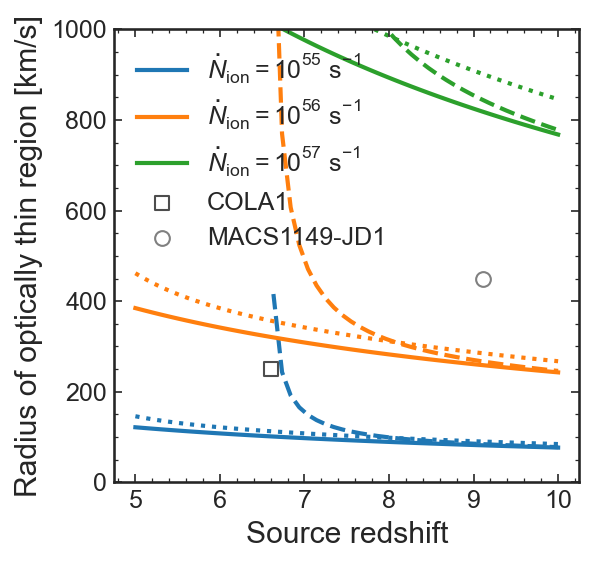

In [9]:
ztab = np.linspace(5., 10)
Ndot_ion_tab = np.logspace(55, 57, 3)/u.s

for ob in observations:
    plt.scatter(observations[ob]['z'], observations[ob]['vlim'], 
                lw=1, edgecolors=observations[ob]['c'], facecolor='w', 
                s=50, marker=observations[ob]['ms'], 
                zorder=100, label=ob)
#     plt.annotate(ob, xy=(observations[ob]['z']-0.1, observations[ob]['vlim']), 
#                  xycoords='data', ha='right', va='center')

for Ndot_ion in Ndot_ion_tab:
    R_alpha = bubbles.R_optically_thin(z=ztab, Ndot_ion=Ndot_ion, alpha_s=-1.8, fesc=1)    
    vlim    = bubbles.blue_velocity_lim(R_alpha, ztab)    
    ln = plt.plot(ztab, vlim, label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion.value))

    R_alpha = bubbles.R_optically_thin(z=ztab, Ndot_ion=Ndot_ion, alpha_s=-1.8, fesc=1, J_bg=50)    
    vlim    = bubbles.blue_velocity_lim(R_alpha, ztab)   
    plt.plot(ztab, vlim, c=ln[0].get_color(), ls='dashed')

    R_alpha = bubbles.R_optically_thin(z=ztab, Ndot_ion=Ndot_ion, alpha_s=-2.5, fesc=1, J_bg=1)    
    vlim    = bubbles.blue_velocity_lim(R_alpha, ztab)   
    plt.plot(ztab, vlim, c=ln[0].get_color(), ls='dotted')

plt.legend()

plt.ylim(0., 1000)
plt.xlabel('Source redshift')
plt.ylabel('Radius of optically thin region [km/s]')

plt.savefig('../figs/Ralpha_z.pdf', bbox_inches='tight')

## As a function of Ndot_ion

To compare with Bolton & Haehnelt (2007) ~ 2-5 pMpc for Ndot_ion ~ 1-7e57 s^-1

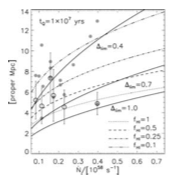

Text(0, 0.5, 'Radius of optically thin region [pMpc]')

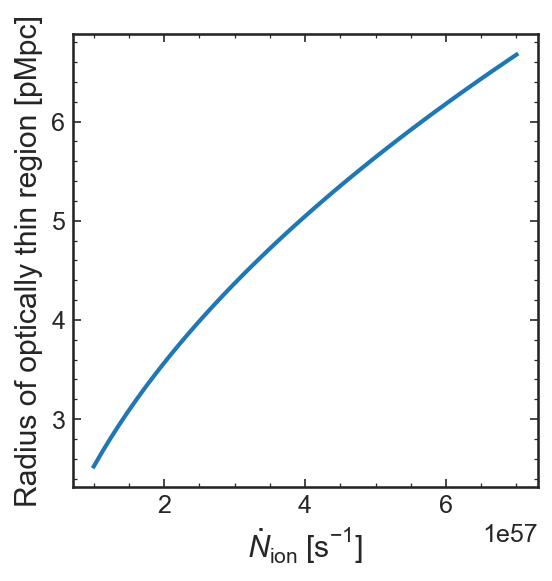

In [10]:
ztest = 6
Ndot_ion_tab = np.linspace(0.1,0.7)*1e58/u.s

R_alpha = bubbles.R_optically_thin(z=ztest, Ndot_ion=Ndot_ion_tab, 
                           reccase='A', alpha_s=-1.5, fesc=1, C=1, Delta=1, T=2e4*u.K)    
    
plt.plot(Ndot_ion_tab, R_alpha)

plt.xlabel('$\dot{N}_\mathrm{ion} \; [$s$^{-1}]$')
plt.ylabel('Radius of optically thin region [pMpc]')

## As a function of UV magnitude

Text(0, 0.5, 'Radius [pMpc]')

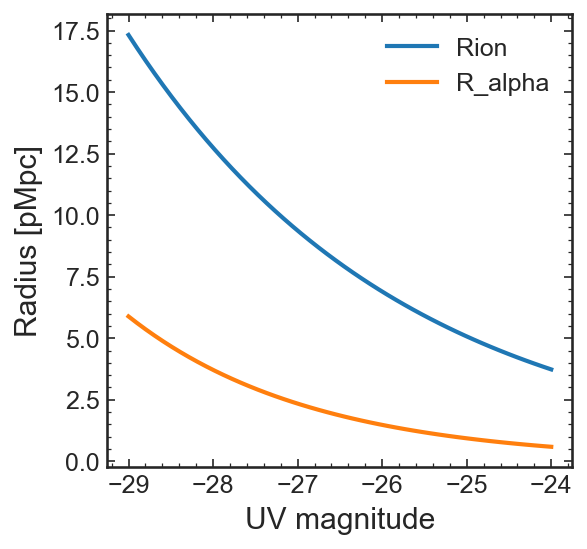

In [11]:
Muv_tab = np.linspace(-24, -18)
Muv_tab = np.linspace(-29, -24)

z_s = 6.

Ndot_ion_tab = bubbles.Muv_to_Nion(Muv_tab, z=z_s, alpha_s=-2, beta=-2)

R_CenHaiman = bubbles.R_bubble_CenHaiman2000(z_s, Ndot_ion=Ndot_ion_tab, t_source=1e8*u.yr)
R_alpha = bubbles.R_optically_thin(z=z_s, Ndot_ion=Ndot_ion_tab, 
                                   reccase='B', alpha_s=-2, 
                                   fesc=1, C=3, Delta=1, T=1e4*u.K, J_bg=1)  
plt.plot(Muv_tab, R_CenHaiman, label='Rion')
plt.plot(Muv_tab, R_alpha, label='R_alpha')

plt.legend()
plt.xlabel('UV magnitude')
plt.ylabel('Radius [pMpc]')

### Compare gamma_BG to source flux

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


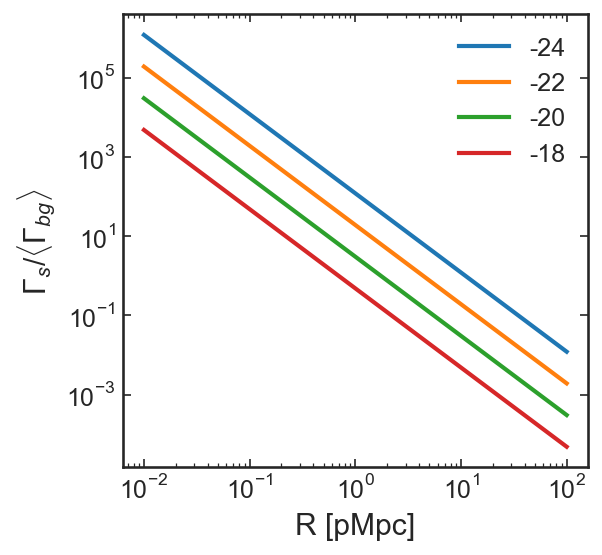

In [295]:
def Gamma12(r, z_s, Ndot_ion, fesc=1., C=3., T=1e4, 
            J_bg=1., alpha=-2):
    """
    R is proper distance

    Neutral fraction from source
    (Mesinger+04)
    
    for fesc = 0.5, Nion = 1e-57/s

    Args:
        J_bg (float): scaling of average UV background
    """    
    # J_source_integrand = bubbles.L_nu(nu_tab, qso=qso, alpha=alpha) * sigma_ion/(bubbles.h_erg_s * nu_tab)
    
    J_source           = fesc * Ndot_ion * (alpha/(alpha - 3)) * bubbles.sigma_ion0

    Gamma12_source     = fesc/(4. * np.pi * r**2.) * J_source
    Gamma12_background = J_bg * bubbles.Gamma12(z_s) / u.s
    
    return Gamma12_source.to(1./u.s), Gamma12_background

Muv_tab = np.arange(-24, -16, 2)

Ndot_ion_tab = bubbles.Muv_to_Nion(Muv_tab, z=7, alpha_s=-2, beta=-2)

Rtab = np.logspace(-2, 2) * u.Mpc
for i, Ndot_ion in enumerate(Ndot_ion_tab):
    gamma_s, gamma_bg = Gamma12(r=Rtab, z_s=7., Ndot_ion=Ndot_ion, fesc=1., C=3., T=1e4, J_bg=1.)
    
    plt.loglog(Rtab, gamma_s/gamma_bg, label=Muv_tab[i])
    
plt.xlabel('R [pMpc]')
plt.ylabel(r'$\Gamma_s/\langle\Gamma_{bg}\rangle$')
plt.legend()

### Plot R_alpha(Muv)

In [38]:
def get_vlim(z, alpha_s, fesc, C, Delta, beta=-2, J_bg=0):
    """
    Minimum velocity [km/s] given size of R_alpha(Muv, alpha, fesc, C, beta)
    """
    
    Ndot_ion_tab = bubbles.Muv_to_Nion(Muv_tab, z=z, alpha_s=alpha_s, beta=beta)

    R_alpha = bubbles.R_optically_thin(z=z, Ndot_ion=Ndot_ion_tab, 
                               reccase='B', alpha_s=alpha_s, 
                               fesc=fesc, C=C, Delta=Delta, T=1e4*u.K, J_bg=J_bg)        

    vlim = bubbles.blue_velocity_lim(R_alpha, z)  
    
    return vlim

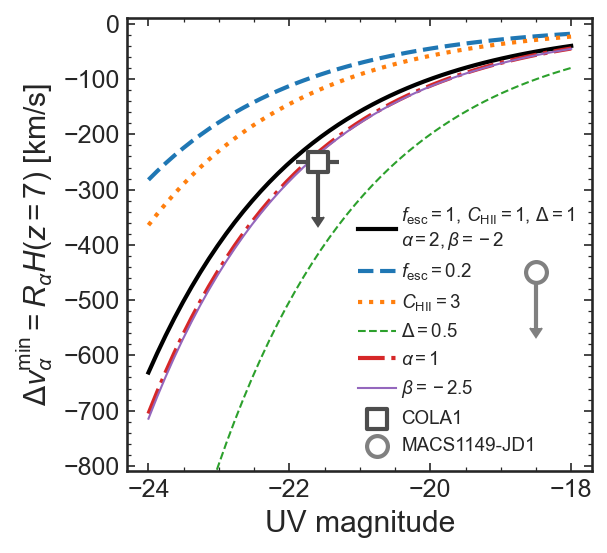

In [39]:
Muv_tab = np.linspace(-24, -18)
z = 7

alpha_fid = -2.
fesc_fid  = 1.
C_fid     = 1 #3.
Delta_fid = 1.
beta_fid  = -2.

alpha_test = -1.
fesc_test  = 0.2
C_test     = 3
Delta_test = 0.5
beta_test  = -2.5

ls = ['solid', 'dashed', 'dotted']
lw = [2, 1, 1]

# Observations
for ob in observations:
    plt.scatter(observations[ob]['M1500'], -observations[ob]['vlim'],
            lw=2, edgecolors=observations[ob]['c'], facecolor='w', 
            s=100, marker=observations[ob]['ms'], 
            zorder=100, label=ob)
    plt.errorbar(observations[ob]['M1500'], -observations[ob]['vlim'], 
                xerr=observations[ob]['M1500_err'], yerr=100, zorder=80,
                lw=2, color=observations[ob]['c'], uplims=True)  

# Fiducial
vlim = get_vlim(z=z, alpha_s=alpha_fid, fesc=fesc_fid, C=C_fid, Delta=Delta_fid, beta=beta_fid)
plt.plot(Muv_tab, -vlim, c='k', label=r'$f_\mathrm{esc}=1,\, C_\mathrm{HII}=1,\, \Delta=1$'+'\n'+r'$\alpha=2, \beta=-2$')

# Change fesc
vlim = get_vlim(z=z, alpha_s=alpha_fid, fesc=fesc_test, C=C_fid, Delta=Delta_fid, beta=beta_fid)
plt.plot(Muv_tab, -vlim, ls='dashed', label=r'$f_\mathrm{esc} = %.1f$' % fesc_test)

# Change C
vlim = get_vlim(z=z, alpha_s=alpha_fid, fesc=fesc_fid, C=C_test, Delta=Delta_fid, beta=beta_fid)
plt.plot(Muv_tab, -vlim, ls='dotted', label=r'$C_\mathrm{HII} = %.0f$' % C_test)

# Change fesc
vlim = get_vlim(z=z, alpha_s=alpha_fid, fesc=fesc_fid, C=C_fid, Delta=Delta_test, beta=beta_fid)
plt.plot(Muv_tab, -vlim, ls='dashed', lw=1, label=r'$\Delta = %.1f$' % Delta_test)

# Change alpha
vlim = get_vlim(z=z, alpha_s=alpha_test, fesc=fesc_fid, C=C_fid, Delta=Delta_fid, beta=beta_fid)
plt.plot(Muv_tab, -vlim, ls='dashdot', label=r'$\alpha = %.0f$' % (-alpha_test))

# Change beta
vlim = get_vlim(z=z, alpha_s=alpha_fid, fesc=fesc_fid, C=C_fid, Delta=Delta_fid, beta=beta_test)
plt.plot(Muv_tab, -vlim, lw=1, label=r'$\beta=%.1f$' % beta_test)

plt.ylim(-810, 10)
plt.xlabel('UV magnitude')
plt.ylabel(r'$\Delta v_\alpha^\mathrm{min} = R_\alpha H(z=%.0f)$ [km/s]' % z)

plt.legend(loc=(0.48, 0.02), ncol=1, fontsize=9, handlelength=2, handletextpad=0.3)
plt.savefig('../figs/Ralpha_Muv_all_1panel.pdf', bbox_inches='tight')

# Infer properties from proximity zone size

Infer:
- alpha_s
- beta
- C
- fesc

## Setup up inference

COLA1:

- Max blue peak = 250 km/s
- R~5000 ==> 60 km/s resolution
- Jorryt says 10 km/s

In [6]:
# Resolution R = l/dl = c/dv
R = 5000.
c = 3e5 * u.km/u.s

v_res = c/R
v_res

<Quantity 60. km / s>

In [7]:
# vlim, sigma_v, Muv, Muv_err, z, fix_bg = 250.*u.km/u.s, 60.*u.km/u.s, -21.6, 0.3, 6.6, True
vlim, sigma_v, Muv, Muv_err, z, fix_bg = 250.*u.km/u.s, 10.*u.km/u.s, -21.6, 0.3, 6.6, True

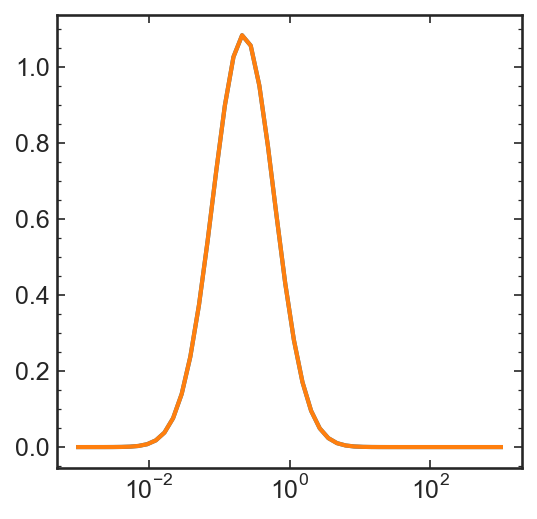

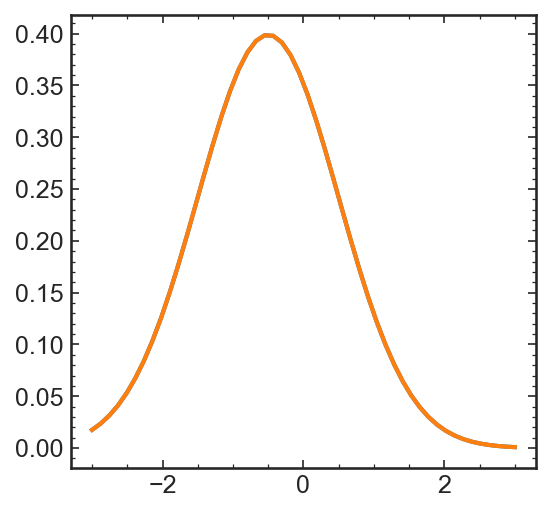

In [35]:
D = np.logspace(-3,3)
def p_lnDelta(D, sigma=1):
    return np.exp(-0.5*(np.log(D) + 0.5*sigma**2.)**2./sigma**2.)/np.sqrt(2.*np.pi)/sigma/D

plt.semilogx(D, p_lnDelta(D, sigma))
plt.plot(D, scipy.stats.lognorm.pdf(D, s=sigma, loc=0, scale=np.exp(-0.5*sigma**2.)))

lnD = np.linspace(-3,3)
def p_lnDelta(lnD, sigma=1):
    return np.exp(-0.5*(lnD + 0.5*sigma**2.)**2./sigma**2.)/np.sqrt(2.*np.pi)/sigma

plt.figure()
sigma=1
plt.plot(lnD, p_lnDelta(lnD, sigma))
plt.plot(lnD, scipy.stats.norm.pdf(lnD, loc=-0.5*sigma**2., scale=sigma))

# Run with emcee

## Fix background = 0

In [4]:
infer_emcee_fixbg = bubbles.blue_peak_inference(vlim, sigma_v, Muv, Muv_err, 
                                                z, fix_bg=True, 
                                                C_bounds=[1., 10.], log_C=False)

Prior bounds: {'fesc': [0.0, 1.0], 'C': [1.0, 10.0], 'alpha_s': [-2.5, -1.0], 'beta': [-3, -1], 'gamma_bg': [0.0, 20.0], 'sigma0': 1.0}


In [5]:
infer_emcee_fixbg = bubbles.blue_peak_inference(vlim, sigma_v, Muv, Muv_err, z, fix_bg=True, C_bounds=[1., 10.], log_C=False)

pos = infer_emcee_fixbg.emcee_setup(nwalkers=100)
pos.shape

Prior bounds: {'fesc': [0.0, 1.0], 'C': [1.0, 10.0], 'alpha_s': [-2.5, -1.0], 'beta': [-3, -1], 'gamma_bg': [0.0, 20.0], 'sigma0': 1.0}


(100, 5)

In [6]:
sampler = infer_emcee_fixbg.emcee_run(pos, Nsteps=2000)

100 walkers, 5 dimensions


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/cmason/opt/anaconda3/envs/astroconda/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 2000/2000 [03:19<00:00, 10.01it/s]
N/50 = 40;
tau: [102.92548942 105.95526853 101.98690487 101.46044622  96.52941669]


Multiprocessing took 199.8 seconds
[102.92548942 105.95526853 101.98690487 101.46044622  96.52941669]


### Plot

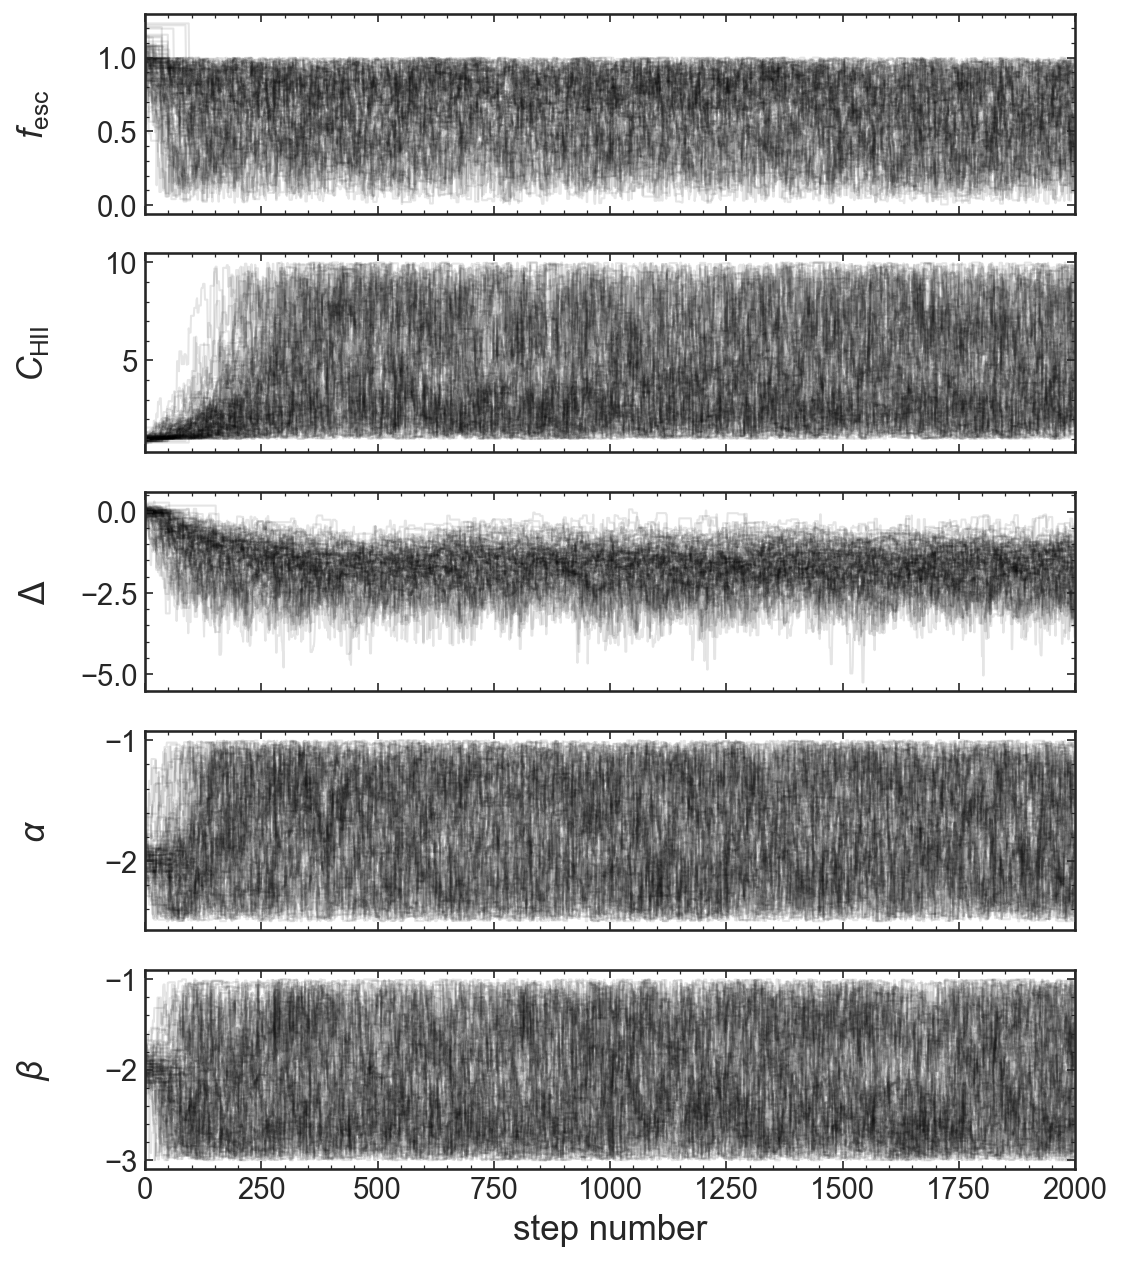

In [9]:
infer_emcee_fixbg.plot_emcee_chains(sampler)

Autocorrelation time suggests that only about 150 steps are needed for the chain to “forget” where it started. 

It’s not unreasonable to throw away a few times this number of steps as “burn-in”. 

Let’s discard the initial 300 steps, thin by about half the autocorrelation time (75 steps), and flatten the chain so that we have a flat list of samples:

Reshaped to: (3600, 5)


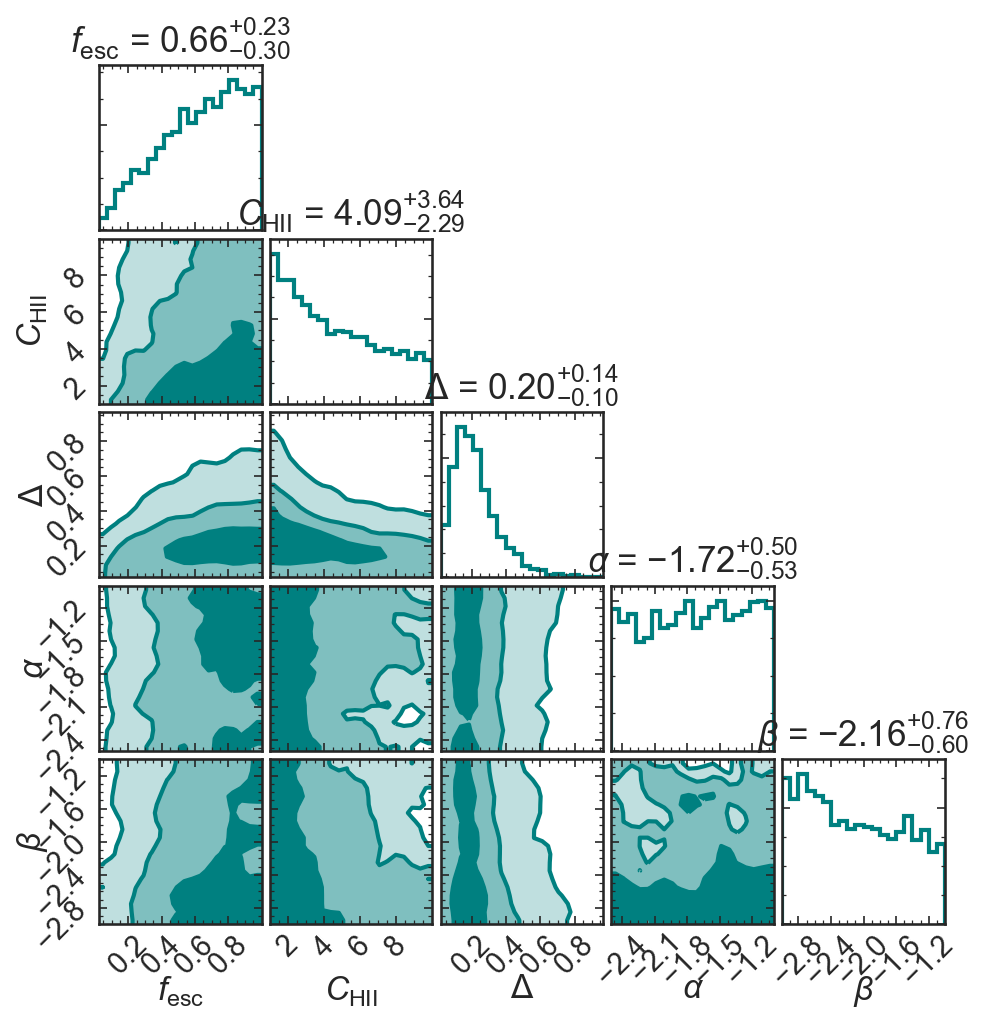

In [8]:
autocorr = 100
infer_emcee_fixbg.plot_emcee_corner(sampler, discard=int(autocorr*2), 
                                    thin=int(autocorr/2), plotname=None)

## Let background free

In [5]:
infer_emcee_freebg = bubbles.blue_peak_inference(vlim, sigma_v, Muv, Muv_err, z, 
                                                fix_bg=False, 
#                                                 gamma_bg_bounds=[0., 100.], log_gamma_bg=False,
                                                gamma_bg_bounds=[-2., 2.], log_gamma_bg=True,
                                                C_bounds=[1., 10.], log_C=False)

Prior bounds: {'fesc': [0.0, 1.0], 'C': [1.0, 10.0], 'alpha_s': [-2.5, -1.0], 'beta': [-3, -1], 'gamma_bg': [-2.0, 2.0], 'sigma0': 1.0}


In [6]:
pos_freebg = infer_emcee_freebg.emcee_setup(nwalkers=100)
pos_freebg.shape

(100, 6)

In [7]:
sampler_freebg = infer_emcee_freebg.emcee_run(pos_freebg, Nsteps=2000)

100 walkers, 6 dimensions


/Users/cmason/opt/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cmason/opt/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cmason/opt/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cmason/opt/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  0%|          | 0/2000 [00:00<?, ?it/s]/Users/cmason/opt/anaconda3/envs/astroconda/lib/python3.6/si

Multiprocessing took 181.9 seconds


N/50 = 40;
tau: [105.25820485 145.11019551  97.54150643 106.78666731 112.18082552
 111.67035913]


[105.25820485 145.11019551  97.54150643 106.78666731 112.18082552
 111.67035913]


### plot

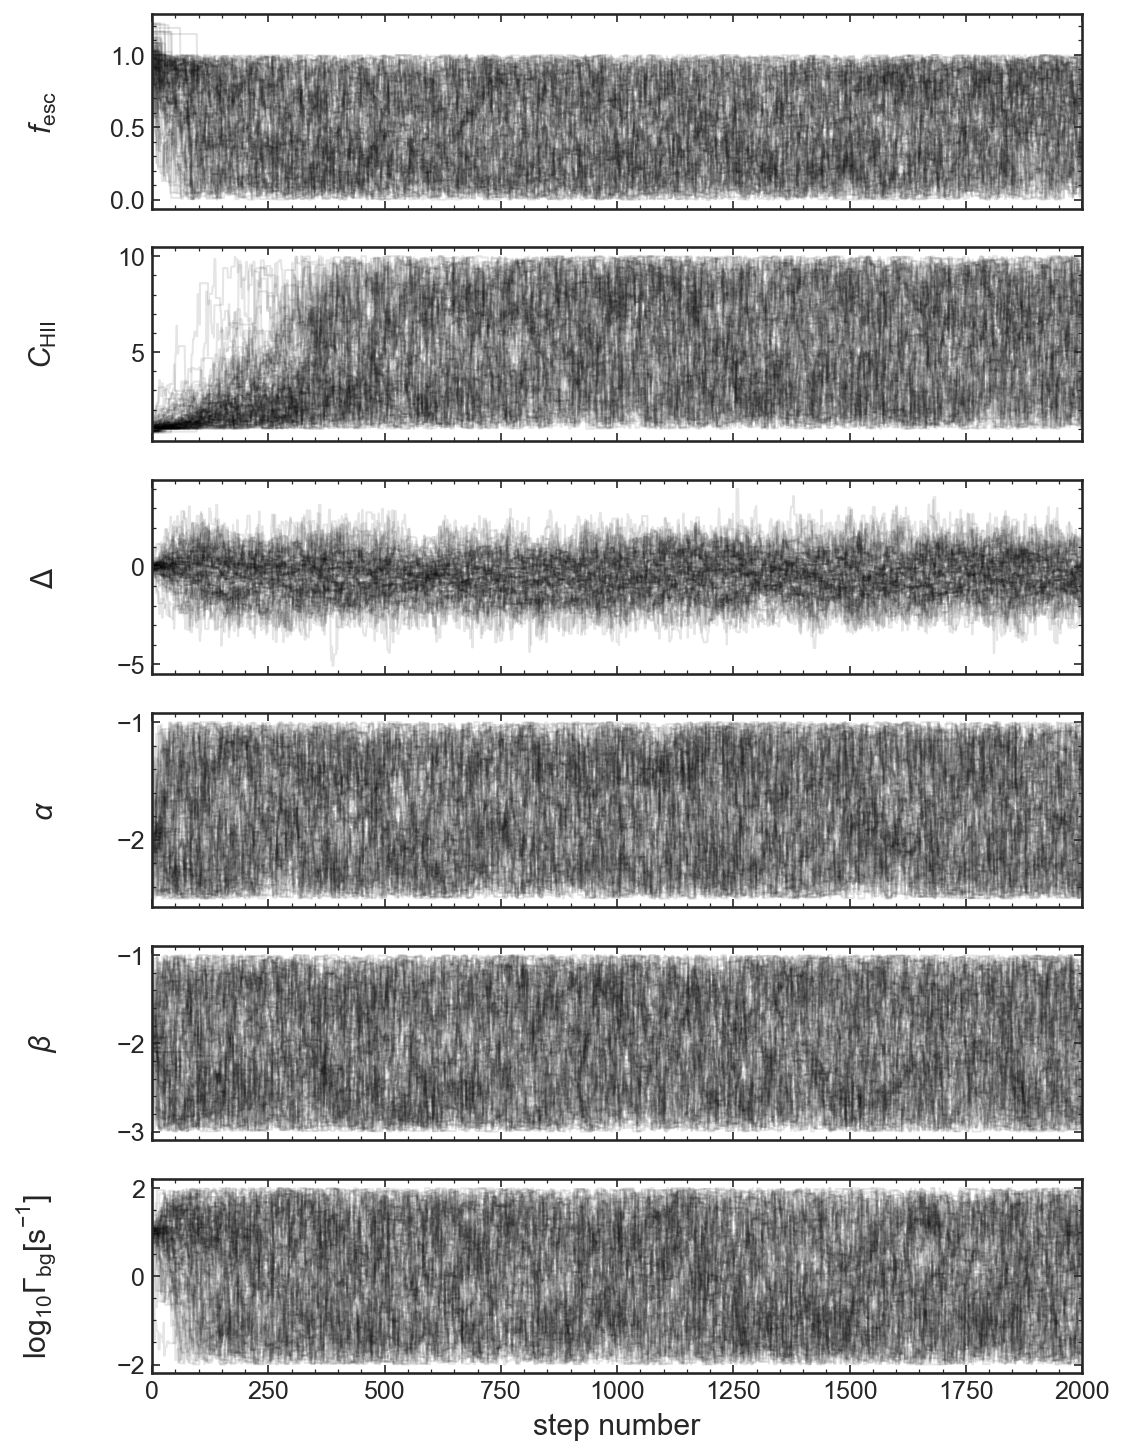

In [8]:
infer_emcee_freebg.plot_emcee_chains(sampler_freebg)

Reshaped to: (3600, 6)


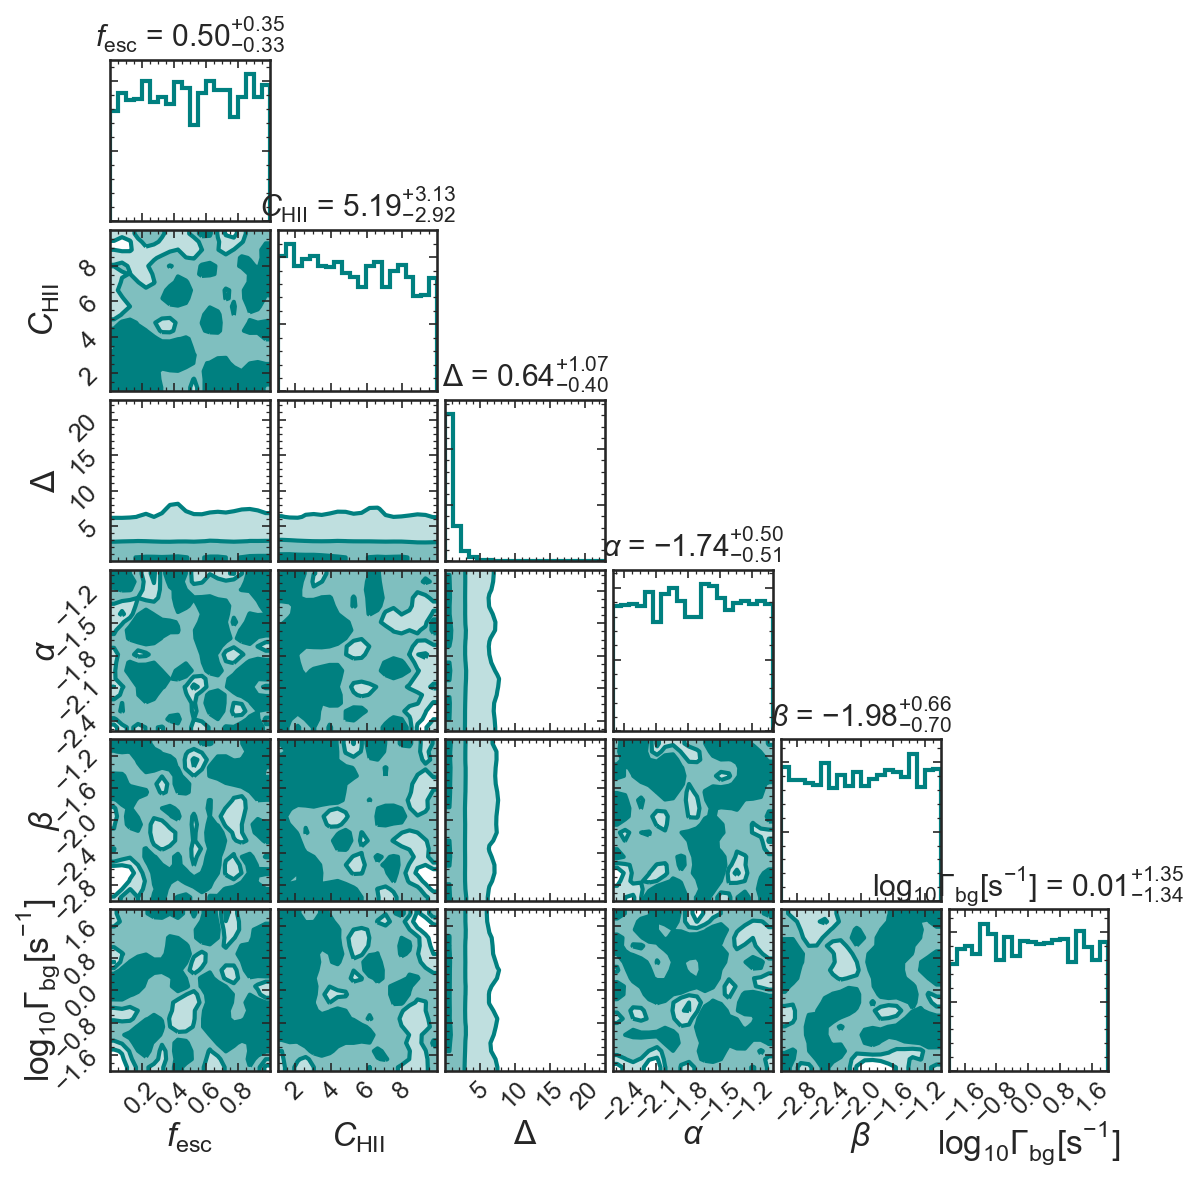

In [9]:
autocorr = 100#100
infer_emcee_freebg.plot_emcee_corner(sampler_freebg, discard=int(autocorr*2), thin=int(autocorr/2), 
                                     smooth=1, plotname=None)

### Plot both

# Run with dynesty

## Prior on Delta

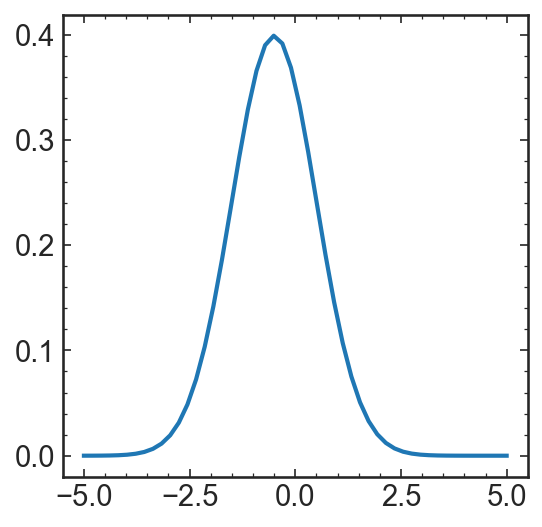

In [60]:
def p_lnDelta(lnD, sigma0=1):
    return scipy.stats.norm.pdf(lnD, loc=-0.5*sigma0**2., scale=sigma0)

lnD = np.linspace(-5,5)
plt.plot(lnD, p_lnDelta(lnD))

## Plots setup

In [269]:
labels = [r'$f_\mathrm{esc}$', r'$C_\mathrm{HII}$', r'$\log_{10} \Delta$', r'$\alpha$', r'$\beta$']
labels_bg = [r'$f_\mathrm{esc}$', r'$C_\mathrm{HII}$', r'$\log_{10} \Delta$', r'$\alpha$', r'$\beta$', r'$\log_{10} \Gamma_\mathrm{bg} [\mathrm{s}^{-1}]$'] #r'$\Gamma_\mathrm{bg} [10^{-12} \mathrm{s}^{-1}]$']

In [270]:
def get_med_errs(array, quantiles=[16., 50., 84.]):
    return [np.percentile(array, q) for q in quantiles]

def plot_compare_corner(samples1, samples2, 
                        logZ1, logZ2,
                        labels=labels,
                        smooth=2,
                        col1='#8D8085', col2='#07205C', 
                        plotname='COLA1_Ralpha_corner_both_bg100.pdf'):
    
    # priors
    x = np.linspace(-15,10, 1000)
    sigma0 = 1.
    p_log10_D = np.log(10)*scipy.stats.norm.pdf(x*np.log(10), loc=-0.5*sigma0**2., scale=sigma0)
    prior = [np.ones(len(x)), # fesc
             np.ones(len(x)), # C
             p_log10_D/np.max(p_log10_D), # log10_delta
             np.ones(len(x)), # alpha
             np.ones(len(x)), # beta
             np.ones(len(x))] # gamma
    
    # make alpha positive
    samples1[:,3] = -samples1[:,3]
    samples2[:,3] = -samples2[:,3]
    
    # Make Delta log
    samples1[:,2] = np.log10(np.exp(samples1[:,2]))
    samples2[:,2] = np.log10(np.exp(samples2[:,2]))
    
    fig, ax = plt.subplots(samples1.shape[1], samples1.shape[1], 
                           figsize=(1.8*samples1.shape[1], 1.8*samples1.shape[1]), dpi=150)

    plot_density = False
    fill_contours = True
    plot_datapoints = False
    
    # With background
    corner.corner(samples1, fig=fig,
                    labels=labels_bg, smooth=smooth, 
                    color=col1, use_math_text=True,
                    plot_datapoints=plot_datapoints, 
                    plot_density=plot_density, 
                    fill_contours=fill_contours, 
                    contour_kwargs={'alpha':1, 'linewidths':1, 'zorder':3},
                    hist_kwargs={'lw':1, 'density':True},
                    levels = 1.0 - np.exp(-0.5 * np.array([1,2]) ** 2),
                    label_kwargs={"fontsize": 16})

    # No background
    expand_samples2 = samples2.copy()
    expand_samples2 = np.append(expand_samples2, -5 + np.random.normal(0., 1, (len(expand_samples2),1)), 1)
    for i,j in it.product(range(samples2.shape[1]), range(samples2.shape[1])):
        # 2D hist
        if i > j:
            corner.hist2d(expand_samples2[:,j], expand_samples2[:,i], 
                          ax=ax[i,j], bins=20, 
                          levels=1.0 - np.exp(-0.5 * np.array([1,2]) ** 2), 
                          smooth=smooth, color=col2, 
                          contour_kwargs={'linewidths':1.5, 'zorder':100},
#                           contourf_kwargs={'alpha':0.5},
                          plot_datapoints=plot_datapoints, 
                          plot_density=plot_density, 
                          fill_contours=fill_contours, 
                          plot_contours=True, 
                          no_fill_contours=False)
            
            xmin, xmax = np.min(samples1[:,j]), np.max(samples1[:,j])
            ymin, ymax = np.min(samples1[:,i]), np.max(samples1[:,i])
            
            xlim = list(ax[i,j].get_xlim())
            ylim = list(ax[i,j].get_ylim())
                        
            if xlim[0] > xmin: xlim[0] = xmin
            if xlim[1] < xmax: xlim[1] = xmax
            if ylim[0] > ymin: ylim[0] = ymin
            if ylim[1] < ymax: ylim[1] = ymax
                
            ax[i,j].set_xlim(xlim)
            ax[i,j].set_ylim(ylim)
            
        # diagonal
        if i == j:        
            data = expand_samples2[:,i]
            n, bins, patches = ax[i,j].hist(data, bins=20, histtype='step', color=col2, density=True, lw=2)
            
            ylim = ax[i,j].get_ylim()
            if 1.1*np.max(n) > ylim[1]:
                ax[i,j].set_ylim(0., 1.1*np.max(n))
            
            # Priors
            ax[i,j].plot(x, np.max(n)*prior[i], c='k', ls='dashed', lw=1, zorder=0)
    
    ymax_gamma = max(ax[-1,-1].get_children()[0].get_xy()[:,1])
    ax[-1,-1].plot(x, ymax_gamma*prior[-1], c='k', ls='dashed', lw=1, zorder=0)
    
    # Legend
    for i, label in enumerate(labels_bg):    
        if i == 0 or i==3: # fesc or alpha
            low_lim2 = get_med_errs(expand_samples2[:,i], quantiles=[100-68.])
            text2 = '%s$> %.2f$' % (label, low_lim2[0]) # fesc
            
            low_lim1 = get_med_errs(samples1[:,i], quantiles=[100-68.])
            text1 = '%s$> %.2f$' % (label, low_lim1[0]) # fesc
        
        elif i==5: # gamma
            low_lim1 = get_med_errs(samples1[:,i], quantiles=[100-68.])
            text1 = '%s$> %.1f$' % (label, low_lim1[0])
            text2 = ''
            
        elif i == 1 or i==4: # C or beta
            up_lim2 = get_med_errs(expand_samples2[:,i], quantiles=[68.])
            text2 = '%s$< %.2f$' % (label, up_lim2[0])
            
            up_lim1 = get_med_errs(samples1[:,i], quantiles=[68.])
            text1 = '%s$< %.2f$' % (label, up_lim1[0])    
        
        else: # delta
            low, med, high = get_med_errs(expand_samples2[:,i])
            low_err, high_err = med-low, high-med
            text2 = '%s$= %.2f_{-%.2f}^{+%.2f}$' % (label, med, low_err, high_err)

            low, med, high = get_med_errs(samples1[:,i])
            low_err, high_err = med-low, high-med
            text1 = '%s$= %.2f_{-%.2f}^{+%.2f}$' % (label, med, low_err, high_err)
            
        ax[i,i].annotate(r'%s' % text1, xy=(0.5,1.05), xycoords='axes fraction', fontsize=13, ha='center', color=col1)
        ax[i,i].annotate(r'%s' % text2, xy=(0.5,1.2), xycoords='axes fraction', fontsize=13, ha='center', color=col2)

    ax[0,1].annotate('No background ($\ln{Z} = %.2f$)' % logZ2, 
                     xy=(0.,0.85), xycoords='axes fraction', color=col2, fontsize=20)

    ax[0,1].annotate('With ionizing background ($\ln{Z} = %.2f$)' % logZ1, 
                     xy=(0.,0.65), xycoords='axes fraction', color=col1, fontsize=20)

    plt.savefig('../figs/%s' % plotname, bbox_inches='tight')
    
    return

## Plots

In [247]:
infer_freebg = bubbles.blue_peak_inference(vlim, sigma_v, Muv, Muv_err, z, 
                                                 gamma_bg_bounds=[-2., 2.],
#                                                  gamma_bg_bounds=[0., 100.],
                                                 fix_bg=False, log_C=True, log_gamma_bg=True)

Prior bounds: {'fesc': [0.0, 1.0], 'C': [0.0, 1.0], 'alpha_s': [-2.5, -1.0], 'beta': [-3, -1], 'gamma_bg': [-2.0, 2.0], 'sigma0': 1.0}


In [248]:
def load_dynesty_samples(chain_file, save=False):
    """Load dynesty samples and get samples + log Z"""

    res = pickle.load(open(chain_file, 'rb'))

    samples = res.samples  # samples
    weights = np.exp(res.logwt - res.logz[-1])  # normalized weights
    samples = dyfunc.resample_equal(samples, weights) # Resample weighted samples.

    if save:
        np.save(chain_file.replace('.pickle','_samples'), samples)
    
    
    print(res.logz[-1], res.logzerr[-1])
    return samples, res.logz[-1]

In [267]:
chain_file_nobg = "../chains/res_nobg_gamma10_fixNion_lnD_fixverr_N=10000.pickle"
flat_samples_nobg_dynesty, logZ_nobg = load_dynesty_samples(chain_file_nobg)

chain_file_bg = "../chains/res_gamma10_-14to-10_fixNion_lnD_fixverr_N=10000.pickle"
flat_samples_bg_dynesty, logZ_withbg = load_dynesty_samples(chain_file_bg)

print(flat_samples_nobg_dynesty.shape, flat_samples_bg_dynesty.shape)

-1.4966836441614013 0.07637937123386815
-0.8125697080505809 0.11200813274755399
(10000, 5) (12418, 6)


0.6841139361108204 1.9820148654581407
-0.8125697080505809 -1.4966836441614013 0.6841139361108204


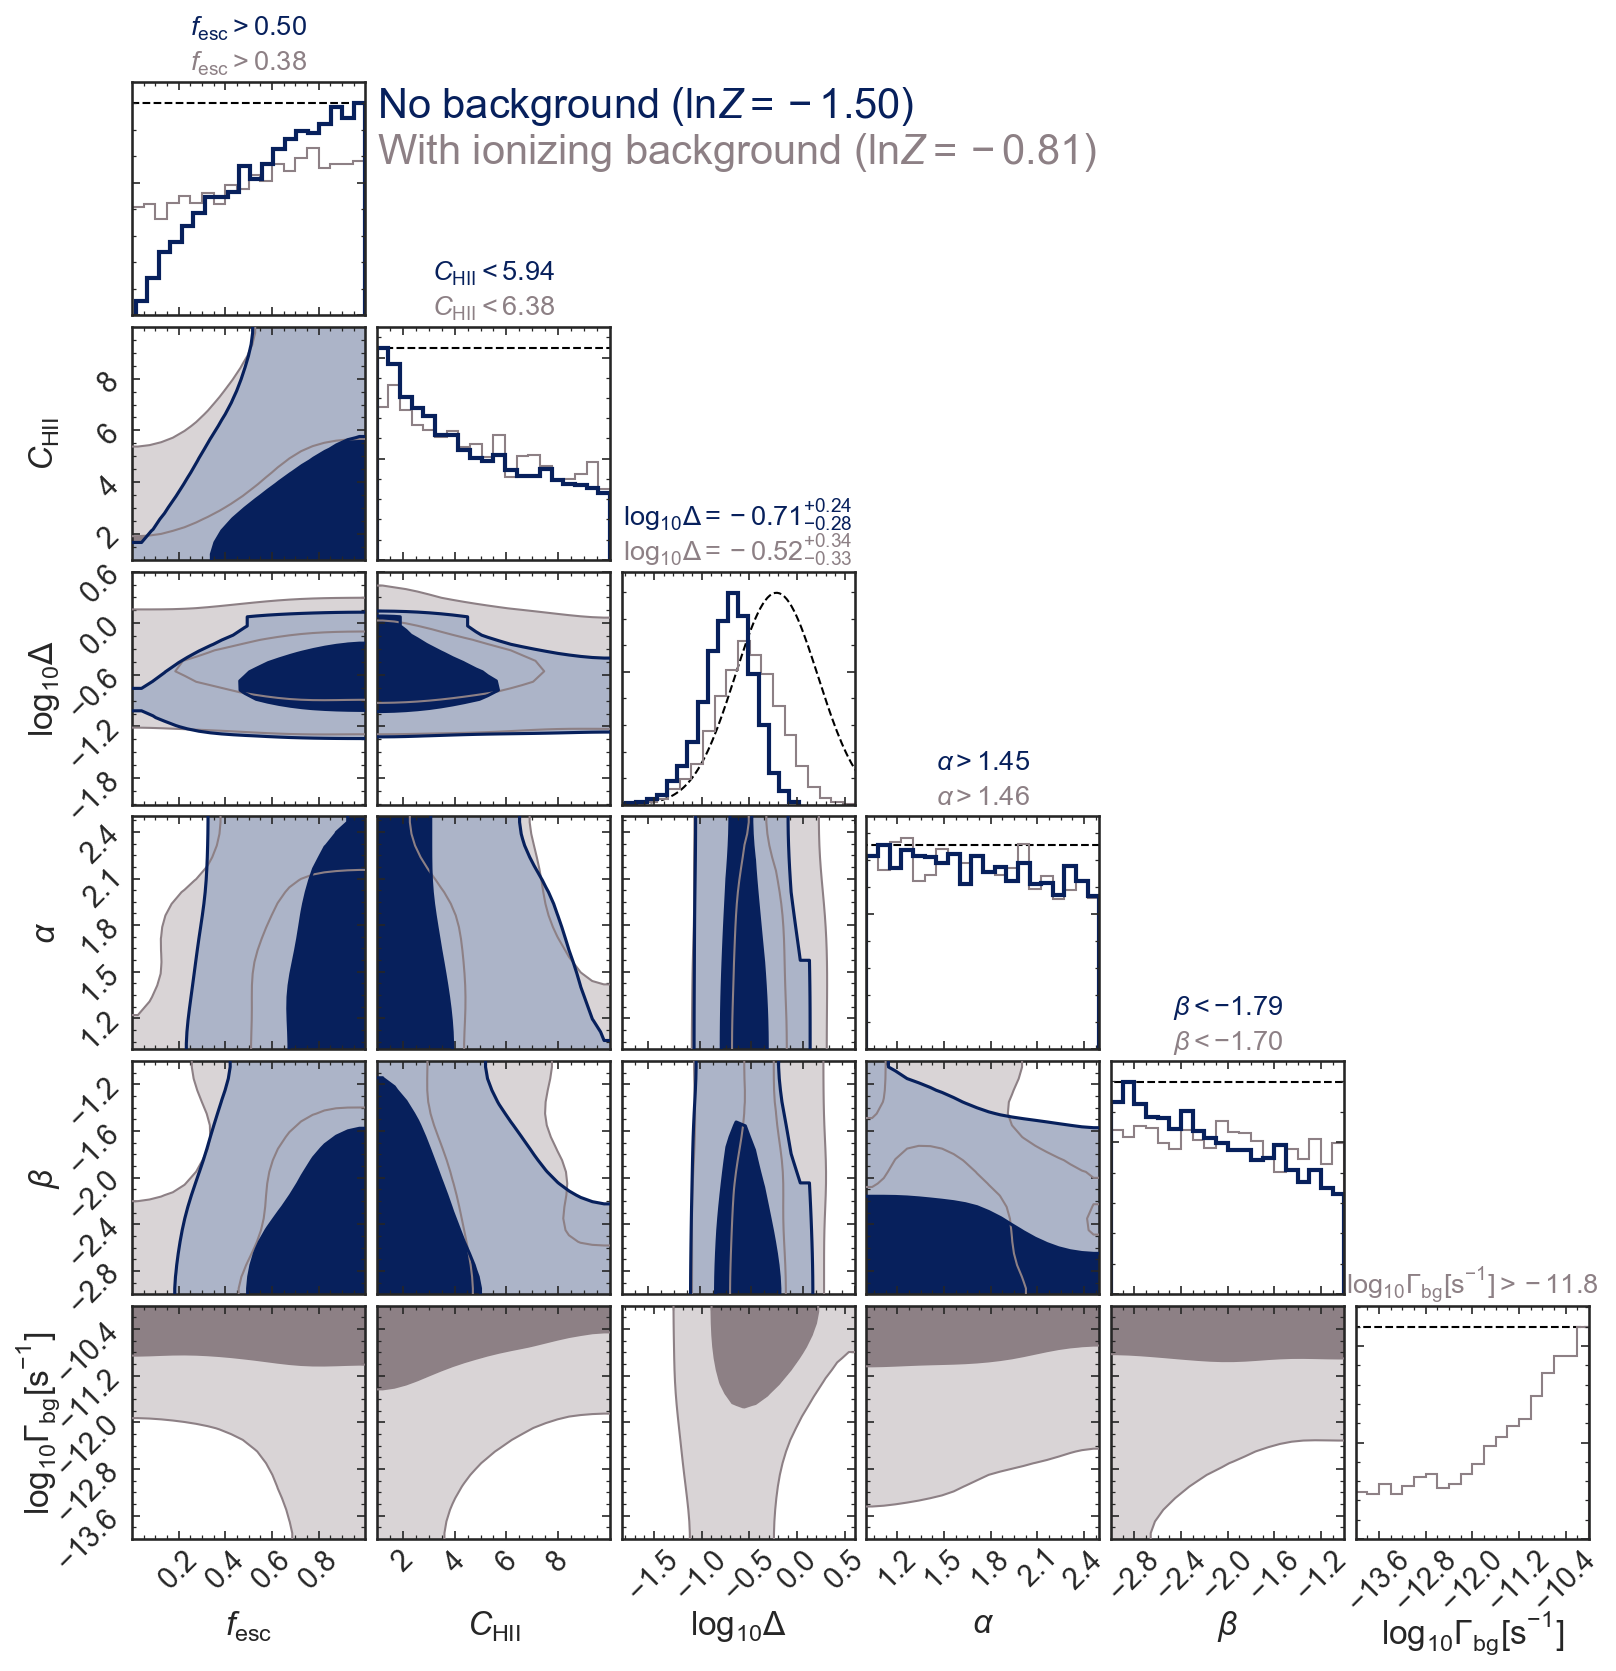

In [271]:
plot_compare_corner(samples1=flat_samples_bg_dynesty.copy(), samples2=flat_samples_nobg_dynesty.copy(), 
                    logZ1=logZ_withbg, logZ2=logZ_nobg,
                    labels=labels, smooth=3,
                    col1='#8D8085', col2='#07205C', 
                    plotname='COLA1_Ralpha_corner_fixNion_fixverr_logD.pdf')

logBF = logZ_withbg - logZ_nobg
print(logBF, np.exp(logBF))
print(logZ_withbg, logZ_nobg, logBF)

# For same Nion what is xHI in from a single source or multiple?

1.3866650680111756 Mpc


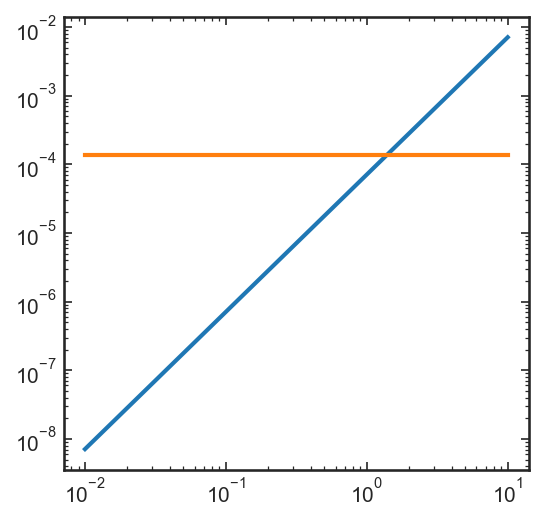

In [63]:
def gamma_s(Ndot_ion=1e55/u.s, fesc=1, alpha=-2):
    sigma_ion0 = 6.3e-18 * u.cm**2
    return -fesc * Ndot_ion * (alpha/alpha-3) * sigma_ion0

def xHI(gamma_s, C=3, z=7, T=1e4):
    return C*bubbles.n_H(z)*bubbles.alpha_rec_B(T)/gamma_s

R_tab = np.logspace(-2,1) * u.Mpc # proper
z_s0 = 7.
Ndot_ion = 1e55/u.s

R_ion = bubbles.R_bubble_CenHaiman2000(z_s0, Ndot_ion=Ndot_ion, t_source=1e8*u.yr)
print(R_ion)

gamma = gamma_s(Ndot_ion=Ndot_ion)

gamma_single_source = gamma/4./np.pi/R_tab.to(u.cm)**2.

plt.loglog(R_tab, xHI(gamma_single_source, z=z_s0))
plt.loglog(R_tab, xHI(gamma/4./np.pi/R_ion.to(u.cm)**2., z=z_s0)*np.ones_like(R_tab))

# source spread through whole bubble


# Simple R_alpha equation

$$R_\alpha^2 = \left(\frac{\sigma_{ion,0}}{4\pi^{3/2} v_{th} \sigma_0}\right) (C n_H(z))^{-2} f_{esc} N_{ion} \frac{\alpha}{\alpha -3} \frac{H(z) \tau_{lim}}{\alpha_B(T)} $$

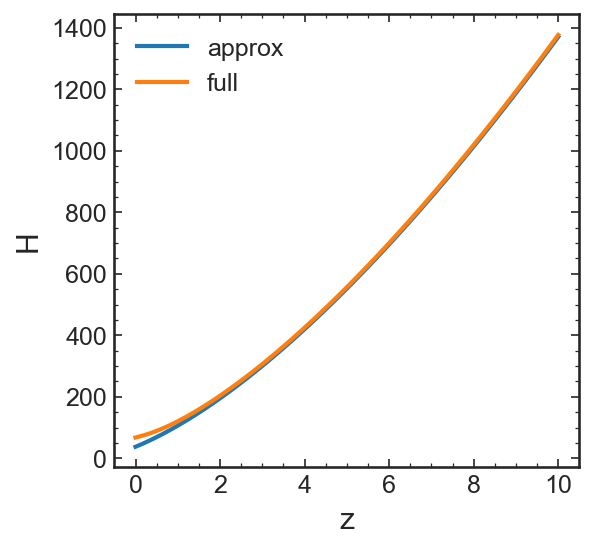

In [14]:
def H(z):
    return np.sqrt(Planck15.Om0) * Planck15.H0 * (1+z)**1.5

ztab = np.linspace(0, 10)

plt.plot(ztab, H(ztab), label='approx')
plt.plot(ztab, Planck15.H(ztab), label='full')

plt.xlabel('z')
plt.ylabel('H')

plt.legend()

2.591815677359873e-13 cm3 / s


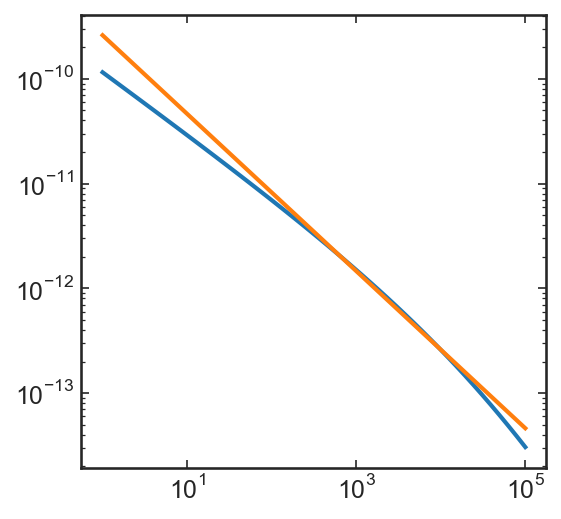

In [15]:
T = np.logspace(0, 5)
print(bubbles.alpha_rec_B(1e4))
plt.loglog(T, bubbles.alpha_rec_B(T))
plt.loglog(T, 2.6e-13*u.cm**3./u.s * (T/1e4)**-0.75 )


In [16]:
z_fid        = 7
fesc_fid     = 1
Ndot_ion_fid = 1e55/u.s
alpha_fid    = -2
tau_lim_fid  = 2.3
C_fid        = 3
T_fid        = 1e4*u.K

def R_alpha(z=z_fid, 
            Ndot_ion=Ndot_ion_fid, fesc=fesc_fid, alpha=alpha_fid, 
            tau_lim=tau_lim_fid, C=C_fid, T=T_fid):
    
    sigma_ion0 = 6.3e-18 * u.cm**2
    sigma_Lya0 = 5.9e-14 * (T/1.e4/u.K)**-0.5 * u.cm**2.
    v_therm    = (1./np.sqrt(const.m_p/2./const.k_B/T)).to(u.km/u.s)
    
    prefactor = (sigma_ion0/4./np.pi**1.5/v_therm/sigma_Lya0)
    
    nH0 = 1.88e-7 * u.cm**(-3)
    nH = nH0 * (1+z)**3
    
    Hz0 = np.sqrt(Planck15.Om0) * Planck15.H0
    Hz  = Hz0 * (1+z)**1.5
    
#     alpha_rec = bubbles.alpha_rec_B(T.value)
    alpha_rec = 2.6e-13*u.cm**3./u.s * (T.value/1e4)**-0.75 
    
    R2 = prefactor * fesc * Ndot_ion * (alpha/(alpha-3)) * tau_lim \
            / (alpha_rec) / C**2. \
            * (Hz0/nH0**2.)*(1+z)**-4.5
    
    return np.sqrt(R2).to(u.Mpc)

R_alpha(z=7, T=1e4*u.K)

<Quantity 0.06767943 Mpc>

In [29]:
def xHI_Ralpha(z=z_fid, tau_lim=tau_lim_fid, T=T_fid, C=C_fid):

    sigma_Lya0 = 5.9e-14 * (T/1.e4/u.K)**-0.5 * u.cm**2.
    v_therm    = (1./np.sqrt(const.m_p/2./const.k_B/T)).to(u.km/u.s)
    prefactor = np.sqrt(np.pi) * v_therm * sigma_Lya0
    
    nH0 = 1.88e-7 * u.cm**(-3)
    nH = nH0 * (1+z)**3
    
    Hz0 = np.sqrt(Planck15.Om0) * Planck15.H0
    Hz  = Hz0 * (1+z)**1.5

    xHI = Hz0/C/nH0 * (1+z)**(-1.5) * tau_lim/prefactor
    return xHI.to(u.cm/u.cm)

def xHI_Ralpha_approx(z, tau_lim, C):
    return 1.63e-6 * ((1+z)/8)**-1.5 * (tau_lim/2.3) * (3/C)


print(xHI_Ralpha())
print(xHI_Ralpha(z=10, tau_lim=1, C=10))
print(xHI_Ralpha_approx(z=10, tau_lim=1, C=10))

1.63284990010244e-06
1.320947737813858e-07
1.3186422172065585e-07


In [32]:
def nHI_Ralpha(z=z_fid, tau_lim=tau_lim_fid, T=T_fid):
    
    sigma_Lya0 = 5.9e-14 * (T/1.e4/u.K)**-0.5 * u.cm**2.
    v_therm    = (1./np.sqrt(const.m_p/2./const.k_B/T)).to(u.km/u.s)
    prefactor = np.sqrt(np.pi) * v_therm * sigma_Lya0
    
    Hz0 = np.sqrt(Planck15.Om0) * Planck15.H0

    nHI = tau_lim * Hz0 * (1+z)**1.5/prefactor
    return nHI.to(u.cm**-3)

nHI_Ralpha(tau_lim=1)

<Quantity 2.05006435e-10 1 / cm3>

# Nion (Muv) calculation checks

## Check Nion(Muv) approx

Text(0.5, 0, 'UV magnitude, $M_{1500}$')

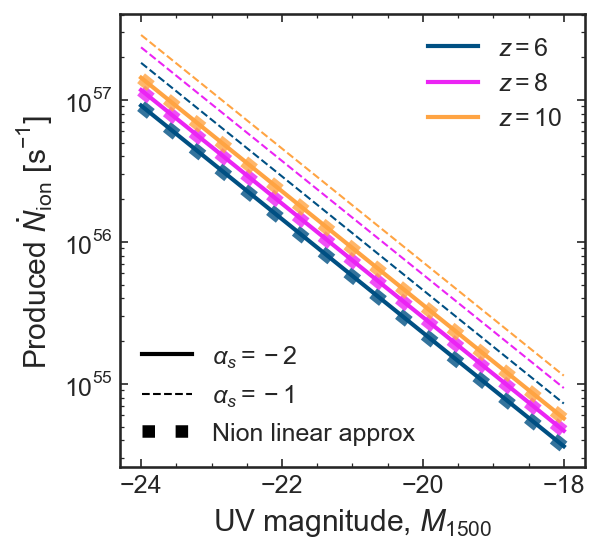

In [10]:
from palettable.cubehelix import cubehelix3_16
col = cubehelix3_16.hex_colors

def Nion_from_Muv(Muv, z, beta, alpha_s):
    f0 = 3.631E-20*u.erg/u.s/u.Hz/u.cm**2.
    Lnu_912 = 4*np.pi*f0 * (10*u.pc)**2. * (1+z)**-(beta+1) * (912./1500)**(beta+2) * 10**(-0.4*Muv)
    Nion = Lnu_912/const.h/-alpha_s
    return Nion.to(1/u.s)

def Nion_from_Muv_approx(Muv, z, beta, alpha_s):
    N = 2.6e55 * (-2/alpha_s) * 10**(-0.4*(Muv+20))/(1+z)**(beta+2) * ((1+z)/8) * (912/1500)**(beta+2)
    return N/u.s

Muv_tab = np.linspace(-24, -18)
z_test = [6., 8., 10.]
alpha_s_test = [-2., -1.]
lw = [2, 1]
ls = ['solid', 'dashed', 'dotted']

for zz, z in enumerate(z_test):
    # Model
    ln = plt.plot(Muv_tab, bubbles.Muv_to_Nion(Muv_tab, z=z, alpha_s=alpha_s_test[0]), 
                      lw=lw[0], c=col[3+zz*4], ls=ls[0], label='$z=%.0f$' % z)
    # Model different alpha
    plt.semilogy(Muv_tab, bubbles.Muv_to_Nion(Muv_tab, z=z, alpha_s=alpha_s_test[1]), 
                 lw=lw[1], c=ln[0].get_color(), ls=ls[1])
    
    # Nion approx
    plt.semilogy(Muv_tab, Nion_from_Muv_approx(Muv_tab, z=z, beta=-2, alpha_s=alpha_s_test[0]), 
                 ls='dotted', lw=6, c=ln[0].get_color(), alpha=0.8)
    
handles = []
for i, alpha_s in enumerate(alpha_s_test):
    ln = mlines.Line2D([], [], color='k', lw=lw[i], ls=ls[i], label=r'$\alpha_s = %.0f$' % alpha_s)
    handles.append(ln)
ln = mlines.Line2D([], [], color='k', ls='dotted', lw=6, label=r'Nion linear approx')
handles.append(ln)
       
leg = plt.legend(handles=handles, loc='lower left')
plt.gca().add_artist(leg)

plt.legend()
plt.ylabel('Produced $\dot{N}_\mathrm{ion}$ [s$^{-1}$]')
plt.xlabel('UV magnitude, $M_{1500}$')

## Check ionizing continuum cutoff

3.3e+15 Hz, 5.9e+15 Hz, 1.3e+16 Hz


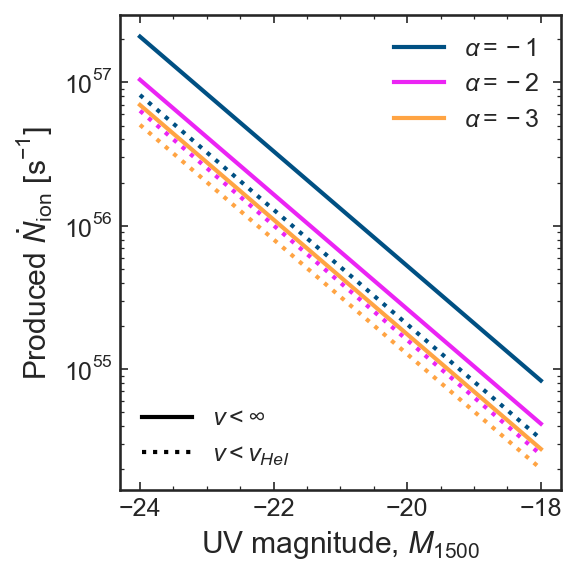

In [11]:
Muv_tab = np.linspace(-24, -18, 10)
Lnu_912 = bubbles.Muv_to_Lnu(Muv_tab, z=6.)

# Cutoffs
nu_HI   = (13.6*u.eV/const.h).to(u.Hz)
nu_HeI  = (24.6*u.eV/const.h).to(u.Hz)
nu_HeII = (54.4*u.eV/const.h).to(u.Hz)
print('{0:.1e}, {1:.1e}, {2:.1e}'.format(nu_HI, nu_HeI, nu_HeII))


nu_tab = np.logspace(np.log10(nu_HI.value), 30, 1000)*u.Hz
for i, alpha in enumerate([-1, -2, -3]):
    
    plt.plot(Muv_tab, bubbles.Muv_to_Nion(Muv_tab, z=7., alpha_s=alpha), 
             c=col[3+i*4], label=r'$\alpha = %.0f$' % alpha)
    
    # Calculate using Lnu*nu*alpha from nu_H to large
    Lnu = Lnu_912[:,None] * (nu_tab/nu_HI)**alpha
    Nion = np.trapz(Lnu/const.h/nu_tab, nu_tab).to(1./u.s)
    
# Calculate using Lnu*nu*alpha from nu_H to nu_HeII
nu_tab = np.logspace(np.log10(nu_HI.value), np.log10(nu_HeI.value), 1000)*u.Hz
for i, alpha in enumerate([-1, -2, -3]):
    Lnu = Lnu_912[:,None] * (nu_tab/nu_HI)**alpha
    Nion = np.trapz(Lnu/const.h/nu_tab, nu_tab).to(1./u.s)
    plt.semilogy(Muv_tab, Nion, c=col[3+i*4], ls='dotted')

ln_infty = mlines.Line2D([], [], color='k', label=r'$\nu < \infty$')
ln_cut = mlines.Line2D([], [], color='k', ls='dotted', label=r'$\nu < \nu_{HeI}$')
handles = [ln_infty, ln_cut]
       
leg = plt.legend(handles=handles, loc='lower left')
plt.gca().add_artist(leg)

plt.legend()

plt.ylabel('Produced $\dot{N}_\mathrm{ion}$ [s$^{-1}$]')
plt.xlabel('UV magnitude, $M_{1500}$')

plt.tight_layout()

### Increase the frequency cut-off 

i.e. don't integrate to infinity

\begin{align}
N_{ion} &= \int_{\nu_H}^{\nu_{max}} d\nu \frac{L_\nu}{h\nu} \\
        &= \frac{L_{912}}{h\alpha} \left[\left(\frac{\nu_{max}}{\nu_H}\right)^\alpha - 1 \right]
\end{align}

Text(0, 0.5, '$\\dot{N}_\\mathrm{ion}/\\dot{N}_\\mathrm{ion,max}$')

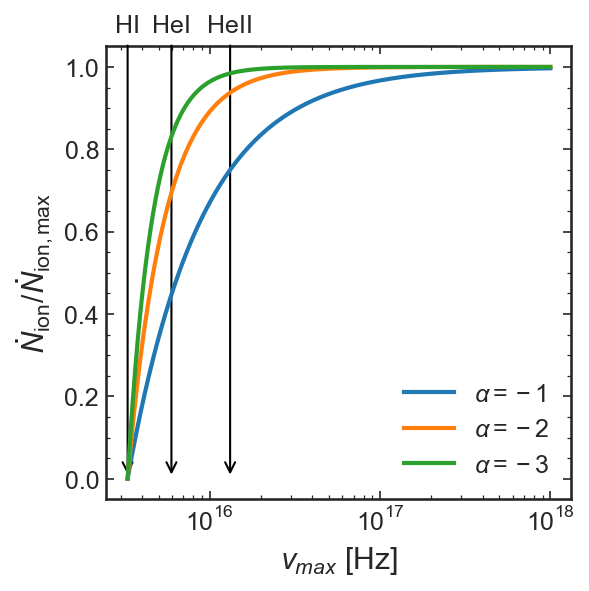

In [15]:
nu_tab = np.logspace(np.log10(nu_HI.value), 18, 1000)*u.Hz

for i, alpha in enumerate([-1, -2, -3]):
    plt.semilogx(nu_tab, -((nu_tab/nu_HI)**alpha - 1), zorder=10, label=r'$\alpha = %.0f$' % alpha)

plt.annotate('HI', xy=(nu_HI.value, 0.), xytext=(nu_HI.value, 1.1), xycoords='data',
             arrowprops={'arrowstyle': '->', 'lw':1}, ha='center', va='center')
plt.annotate('HeI', xy=(nu_HeI.value, 0.), xytext=(nu_HeI.value, 1.1), xycoords='data',
             arrowprops={'arrowstyle': '->', 'lw':1}, ha='center', va='center')
plt.annotate('HeII', xy=(nu_HeII.value, 0.), xytext=(nu_HeII.value, 1.1), xycoords='data',
             arrowprops={'arrowstyle': '->', 'lw':1}, ha='center', va='center')

plt.legend()

plt.xlabel(r'$\nu_{max}$ [Hz]')
plt.ylabel(r'$\dot{N}_\mathrm{ion}/\dot{N}_\mathrm{ion,max}$')

In [13]:
z = 6.
deltaz = 0.5
volume_Mpc3 = Planck15.comoving_volume(z + deltaz) - Planck15.comoving_volume(z - deltaz)
print('{0:.0e}'.format(volume_Mpc3))



4e+11 Mpc3


In [15]:
9*u.arcmin*Planck15.kpc_proper_per_arcmin(z=7)

<Quantity 2887.15614595 kpc>